In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import corner
from tqdm import tqdm

import sys
sys.path.append('../../../dev/wdphoto')
sys.path.append('../../')
sys.path.append('../')

from corecomposition.selection import build, analyze
from corecomposition import photometry
import wdphoto
import configparser

G = 6.674e-11
mass_sun = 1.9884e30
radius_sun = 6.957e8
c = 2.99e8

KeyboardInterrupt: 

## Build The Catalog

In [ ]:
catpath = '../elbadry.csv'
confpath = '../data/gold.ini'
outpath = '../data/broad_sample.csv'

basecat = Table.read(catpath)
config = configparser.ConfigParser()
config.read(confpath)

['../data/gold.ini']

In [ ]:
basecat, targets, engine_keys = build(config, basecat)

Building Catalog


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Found 380 WD+MS Wide Binaries

Measuring Radii


100%|██████████| 380/380 [01:29<00:00,  4.24it/s]


Fit Report:
Warwick failed=1.05%
CO_Hrich failed=5.79%
ONe_Hrich failed=3.68%
CO_Hdef failed=1.05%
ONe_Hdef failed=2.11%
Total failed=13.68%
Found 5 High Mass WD+MS Wide Binaries


## Check The Radii Using MCMC

In [ ]:
bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP']

co_hrich_model = wdphoto.LaPlataUltramassive(bands, core = 'CO', layer = 'Hrich')
co_hdef_model = wdphoto.LaPlataUltramassive(bands, core = 'CO', layer = 'Hdef')

one_hrich_model = wdphoto.LaPlataUltramassive(bands, core = 'ONe', layer = 'Hrich')
one_hdef_model = wdphoto.LaPlataUltramassive(bands, core = 'ONe', layer = 'Hdef')

base_model = wdphoto.LaPlataBase(bands, layer='Hrich')

In [ ]:
astrometric_params_solved = targets['wd_astrometric_params_solved']
bp_mag = targets['wd_phot_bp_mean_mag']
rp_mag = targets['wd_phot_rp_mean_mag']
g_mag = targets['wd_phot_g_mean_mag']
g_flux = targets['wd_phot_g_mean_flux']

g_corr, g_fl_corr = wdphoto.utils.correct_gband(bp_mag, rp_mag, astrometric_params_solved, g_mag, g_flux)

targets['wd_corrected_gmag'] = g_corr
targets['wd_corrected_gflux'] = g_fl_corr

In [ ]:
i = 1
obs_mag = np.array([targets[i]['wd_corrected_gmag'], targets[i]['wd_phot_bp_mean_mag'], targets[i]['wd_phot_rp_mean_mag']])
e_obs_mag = np.array([targets[i]['wd_e_gmag'], targets[i]['wd_e_bpmag'], targets[i]['wd_e_rpmag']])
distance = targets['r_med_geo'][i]

In [ ]:
engine = wdphoto.MCMCEngine(co_hdef_model)
initial_guess = [10000, 0.001]
flat_chain = engine.run_mcmc(obs_mag, e_obs_mag, distance, initial_guess)

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [229.76159774 185.52598954]


Auto-Correlation Time = 229.76159773699752, additional steps = 9447


100%|██████████| 9447/9447 [02:05<00:00, 75.50it/s] 


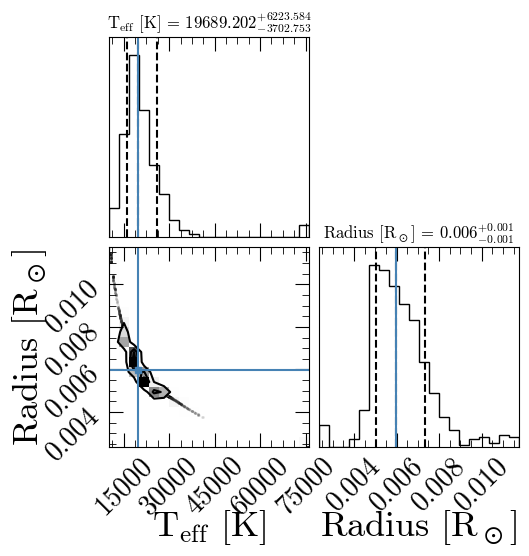

In [ ]:
labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(flat_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(flat_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

In [ ]:
targets[i]

wd_solution_id,ms_solution_id,wd_source_id,ms_source_id,wd_random_index,ms_random_index,wd_ref_epoch,ms_ref_epoch,wd_ra,ms_ra,wd_ra_error,ms_ra_error,wd_dec,ms_dec,wd_dec_error,ms_dec_error,wd_parallax,ms_parallax,wd_parallax_error,ms_parallax_error,wd_parallax_over_error,ms_parallax_over_error,wd_pm,ms_pm,wd_pmra,ms_pmra,wd_pmra_error,ms_pmra_error,wd_pmdec,ms_pmdec,wd_pmdec_error,ms_pmdec_error,wd_ra_dec_corr,ms_ra_dec_corr,wd_ra_parallax_corr,ms_ra_parallax_corr,wd_ra_pmra_corr,ms_ra_pmra_corr,wd_ra_pmdec_corr,ms_ra_pmdec_corr,wd_dec_parallax_corr,ms_dec_parallax_corr,wd_dec_pmra_corr,ms_dec_pmra_corr,wd_dec_pmdec_corr,ms_dec_pmdec_corr,wd_parallax_pmra_corr,ms_parallax_pmra_corr,wd_parallax_pmdec_corr,ms_parallax_pmdec_corr,wd_pmra_pmdec_corr,ms_pmra_pmdec_corr,wd_astrometric_n_obs_al,ms_astrometric_n_obs_al,wd_astrometric_n_obs_ac,ms_astrometric_n_obs_ac,wd_astrometric_n_good_obs_al,ms_astrometric_n_good_obs_al,wd_astrometric_n_bad_obs_al,ms_astrometric_n_bad_obs_al,wd_astrometric_gof_al,ms_astrometric_gof_al,wd_astrometric_chi2_al,ms_astrometric_chi2_al,wd_astrometric_excess_noise,ms_astrometric_excess_noise,wd_astrometric_excess_noise_sig,ms_astrometric_excess_noise_sig,wd_astrometric_params_solved,ms_astrometric_params_solved,wd_astrometric_primary_flag,ms_astrometric_primary_flag,wd_nu_eff_used_in_astrometry,ms_nu_eff_used_in_astrometry,wd_pseudocolour,ms_pseudocolour,wd_pseudocolour_error,ms_pseudocolour_error,wd_ra_pseudocolour_corr,ms_ra_pseudocolour_corr,wd_dec_pseudocolour_corr,ms_dec_pseudocolour_corr,wd_parallax_pseudocolour_corr,ms_parallax_pseudocolour_corr,wd_pmra_pseudocolour_corr,ms_pmra_pseudocolour_corr,wd_pmdec_pseudocolour_corr,ms_pmdec_pseudocolour_corr,wd_astrometric_matched_transits,ms_astrometric_matched_transits,wd_visibility_periods_used,ms_visibility_periods_used,wd_astrometric_sigma5d_max,ms_astrometric_sigma5d_max,wd_matched_transits,ms_matched_transits,wd_new_matched_transits,ms_new_matched_transits,wd_matched_transits_removed,ms_matched_transits_removed,wd_ipd_gof_harmonic_amplitude,ms_ipd_gof_harmonic_amplitude,wd_ipd_gof_harmonic_phase,ms_ipd_gof_harmonic_phase,wd_ipd_frac_multi_peak,ms_ipd_frac_multi_peak,wd_ipd_frac_odd_win,ms_ipd_frac_odd_win,wd_ruwe,ms_ruwe,wd_scan_direction_strength_k1,ms_scan_direction_strength_k1,wd_scan_direction_strength_k2,ms_scan_direction_strength_k2,wd_scan_direction_strength_k3,ms_scan_direction_strength_k3,wd_scan_direction_strength_k4,ms_scan_direction_strength_k4,wd_scan_direction_mean_k1,ms_scan_direction_mean_k1,wd_scan_direction_mean_k2,ms_scan_direction_mean_k2,wd_scan_direction_mean_k3,ms_scan_direction_mean_k3,wd_scan_direction_mean_k4,ms_scan_direction_mean_k4,wd_duplicated_source,ms_duplicated_source,wd_phot_g_n_obs,ms_phot_g_n_obs,wd_phot_g_mean_flux,ms_phot_g_mean_flux,wd_phot_g_mean_flux_error,ms_phot_g_mean_flux_error,wd_phot_g_mean_flux_over_error,ms_phot_g_mean_flux_over_error,wd_phot_g_mean_mag,ms_phot_g_mean_mag,wd_phot_bp_n_obs,ms_phot_bp_n_obs,wd_phot_bp_mean_flux,ms_phot_bp_mean_flux,wd_phot_bp_mean_flux_error,ms_phot_bp_mean_flux_error,wd_phot_bp_mean_flux_over_error,ms_phot_bp_mean_flux_over_error,wd_phot_bp_mean_mag,ms_phot_bp_mean_mag,wd_phot_rp_n_obs,ms_phot_rp_n_obs,wd_phot_rp_mean_flux,ms_phot_rp_mean_flux,wd_phot_rp_mean_flux_error,ms_phot_rp_mean_flux_error,wd_phot_rp_mean_flux_over_error,ms_phot_rp_mean_flux_over_error,wd_phot_rp_mean_mag,ms_phot_rp_mean_mag,wd_phot_bp_n_contaminated_transits,ms_phot_bp_n_contaminated_transits,wd_phot_bp_n_blended_transits,ms_phot_bp_n_blended_transits,wd_phot_rp_n_contaminated_transits,ms_phot_rp_n_contaminated_transits,wd_phot_rp_n_blended_transits,ms_phot_rp_n_blended_transits,wd_phot_proc_mode,ms_phot_proc_mode,wd_phot_bp_rp_excess_factor,ms_phot_bp_rp_excess_factor,wd_bp_rp,ms_bp_rp,wd_bp_g,ms_bp_g,wd_g_rp,ms_g_rp,wd_dr2_radial_velocity,ms_dr2_radial_velocity,wd_dr2_radial_velocity_error,ms_dr2_radial_velocity_error,wd_dr2_rv_nb_transits,ms_dr2_rv_nb_transits,wd_dr2_rv_template_teff,ms_dr2

In [ ]:
assert False

AssertionError: 

## Plot Mass-Radius Models

In [ ]:
sys.path.append('../../')
import WD_models

radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16
speed_light = 299792458 #m/s

def one_model(radarray, teffarray):
    ONe_model = WD_models.load_model('ft', 'ft', 'o', atm_type = 'H', HR_bands = ['bp3-rp3', 'G3'])
    g_acc = (10**ONe_model['logg'])/100
    rsun = np.sqrt(ONe_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**ONe_model['logteff'],\
                                                z = ONe_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

def co_model(radarray, teffarray):
    CO_model = WD_models.load_model('ft', 'c', 'ft', atm_type = 'H', HR_bands = ['bp3-rp3', 'G3'])
    g_acc = (10**CO_model['logg'])/100
    rsun = np.sqrt(CO_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**CO_model['logteff'],\
                                                z = CO_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

def self_mrr_model(radarray, teffarray, model):
    g_acc = (10**model.logg_array) / 100
    rsun = np.sqrt(model.mass_array * mass_sun * newton_G / g_acc) / radius_sun
    
    x_m, y_m, z_m, rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = model.teff_array, z = model.mass_array, interp_type = 'linear')

    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

In [ ]:
teff = np.linspace(5000, 75000, 5)
logg = np.linspace(7, 9.3, 200)

co_hrich_radius = []
co_hrich_mass = []
co_hrich_vg = []
co_hdef_radius = []
co_hdef_mass = []
co_hdef_vg = []

one_hrich_radius = []
one_hrich_mass = []
one_hrich_vg = []
one_hdef_radius = []
one_hdef_mass = []
one_hdef_vg = []

base_radius = []
base_mass = []
base_vg = []

for j in tqdm(range(len(teff))):
    radii = [co_hrich_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]    
    co_hrich_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    co_hrich_mass.append(masses)
    co_hrich_radius.append(radii)

    radii = [co_hdef_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]
    co_hdef_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    co_hdef_mass.append(masses)
    co_hdef_radius.append(radii)

    radii = [one_hrich_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]    
    one_hrich_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    one_hrich_mass.append(masses)
    one_hrich_radius.append(radii)

    radii = [one_hdef_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]
    one_hdef_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    one_hdef_mass.append(masses)
    one_hdef_radius.append(radii)

    radii = [base_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]
    base_vg.append([1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))])
    base_mass.append(masses)
    base_radius.append(radii)

co_hrich_radius = np.array(co_hrich_radius)
co_hrich_mass = np.array(co_hrich_mass)
co_hrich_vg = np.array(co_hrich_vg)
co_hdef_radius = np.array(co_hdef_radius)
co_hdef_mass = np.array(co_hdef_mass)
co_hdef_vg = np.array(co_hdef_vg)

one_hrich_radius = np.array(one_hrich_radius)
one_hrich_mass = np.array(one_hrich_mass)
one_hrich_vg = np.array(one_hrich_vg)
one_hdef_radius = np.array(one_hdef_radius)
one_hdef_mass = np.array(one_hdef_mass)
one_hdef_vg = np.array(one_hdef_vg)

base_radius = np.array(base_radius)
base_mass = np.array(base_mass)
base_vg = np.array(base_vg)


  0%|          | 0/5 [00:00<?, ?it/s]


AttributeError: 'LaPlataUltramassive' object has no attribute 'radius_interp'

Text(0.5, 0, 'Mass $[M_\\odot]$')

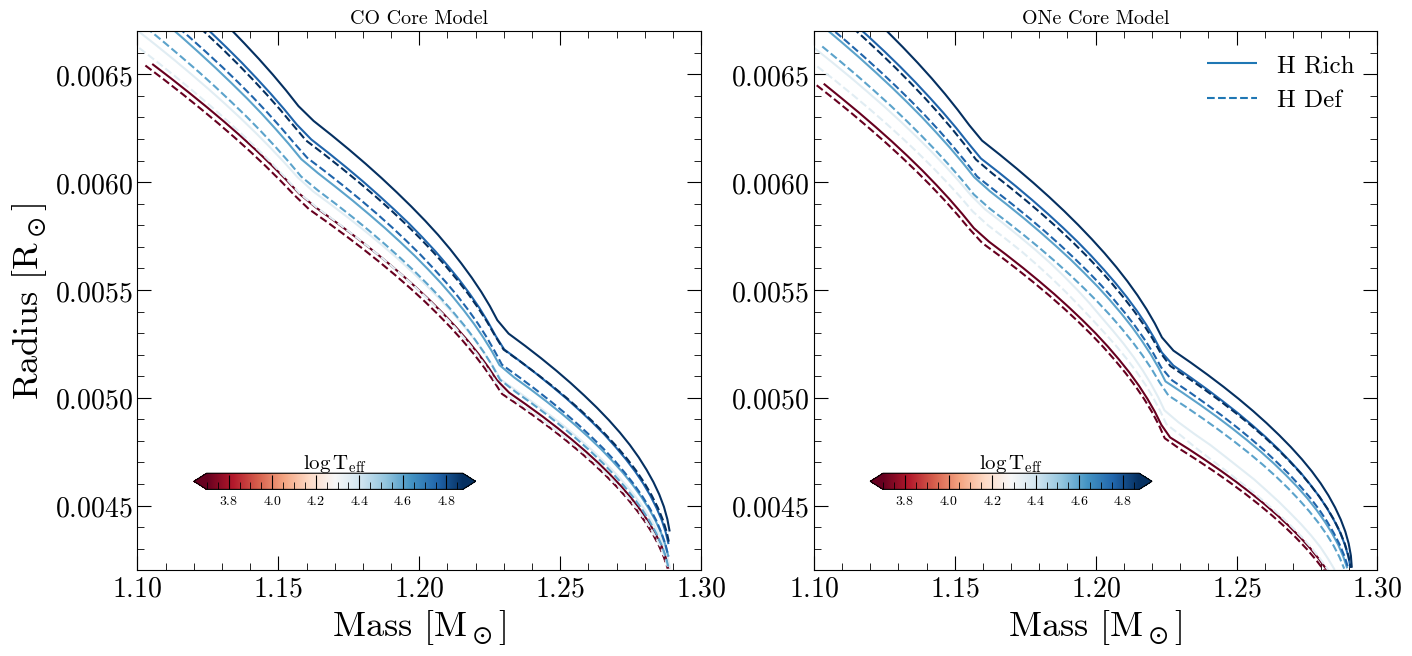

In [ ]:
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 7))

co_hrich_stack = [np.column_stack([x,y]) for x, y in zip(co_hrich_mass, co_hrich_radius)]
co_hdef_stack = [np.column_stack([x,y]) for x, y in zip(co_hdef_mass, co_hdef_radius)]

one_hrich_stack = [np.column_stack([x,y]) for x, y in zip(one_hrich_mass, one_hrich_radius)]
one_hdef_stack = [np.column_stack([x,y]) for x, y in zip(one_hdef_mass, one_hdef_radius)]


ax1.set_xlim(1.1, 1.3)
ax1.set_ylim(0.0042, 0.0067)
ax1.set_title('CO Core Model')

line_collection = LineCollection(co_hrich_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='CO H Rich')
ax1.add_collection(line_collection)
line_collection = LineCollection(co_hdef_stack, array=np.log10(teff), cmap='RdBu', ls = '--', label='CO H Def')
ax1.add_collection(line_collection)

cbaxes = ax1.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(line_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax1.set_xlabel(r'Mass $[M_\odot]$')
ax1.set_ylabel(r'Radius $[R_\odot]$')


ax2.set_xlim(1.1, 1.3)
ax2.set_ylim(0.0042, 0.0067)
ax2.set_title('ONe Core Model')

line_collection = LineCollection(one_hrich_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='H Rich')
ax2.add_collection(line_collection)
line_collection = LineCollection(one_hdef_stack, array=np.log10(teff), cmap='RdBu', ls = '--', label='H Def')
ax2.add_collection(line_collection)

cbaxes = ax2.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(line_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax2.legend(framealpha=0)
ax2.set_xlabel(r'Mass $[M_\odot]$')


Text(0.5, 0, 'Mass $[M_\\odot]$')

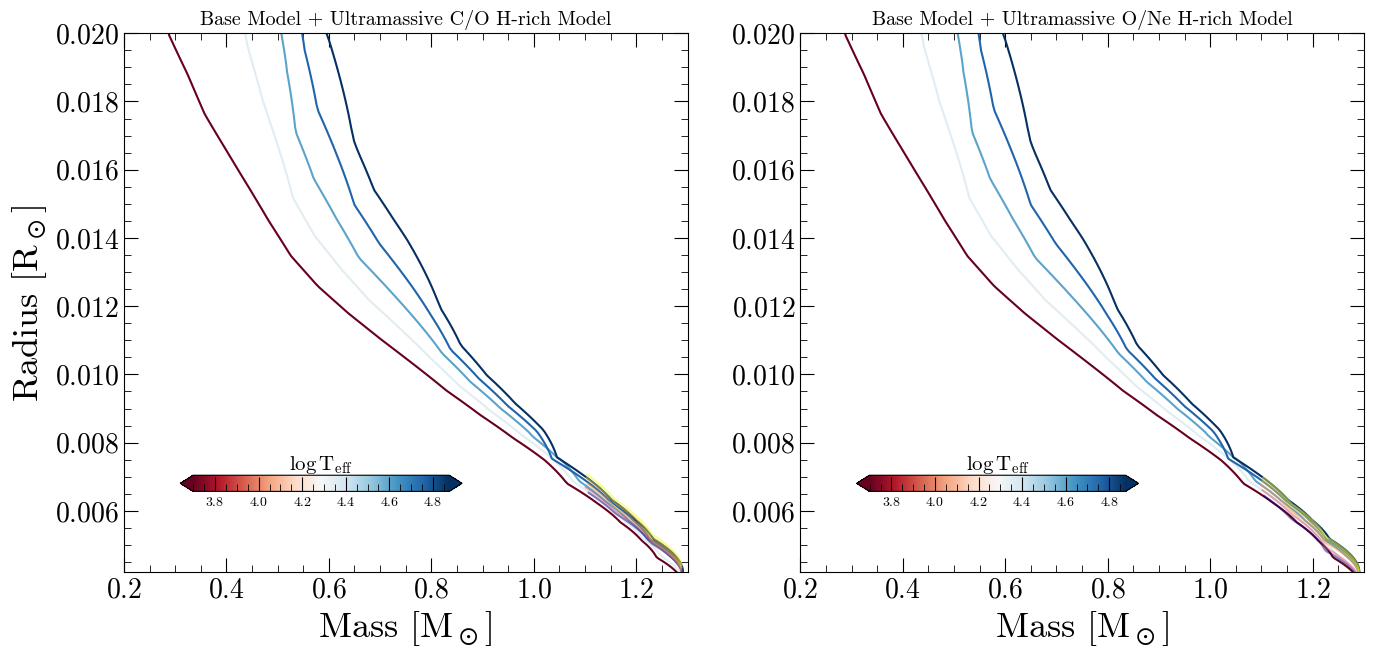

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(16, 7))

mr_base_stack = [np.column_stack([x,y]) for x, y in zip(base_mass, base_radius)]
mr_co_hrich_stack = [np.column_stack([x,y]) for x, y in zip(co_hrich_mass, co_hrich_radius)]
mr_one_hrich_stack = [np.column_stack([x,y]) for x, y in zip(one_hrich_mass, one_hrich_radius)]


ax1.set_xlim(0.2, 1.3)
ax1.set_ylim(0.0042, 0.02)
ax1.set_title('Base Model + Ultramassive C/O H-rich Model')

mr_base_collection = LineCollection(mr_base_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='CO H Rich')
ax1.add_collection(mr_base_collection)
mr_co_collection = LineCollection(mr_co_hrich_stack, array=np.log10(teff), cmap='plasma', ls = '-', label='CO H Rich', alpha = 0.5)
ax1.add_collection(mr_co_collection)

cbaxes = ax1.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(mr_base_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax1.set_xlabel(r'Mass $[M_\odot]$')
ax1.set_ylabel(r'Radius $[R_\odot]$')




ax2.set_xlim(0.2, 1.3)
ax2.set_ylim(0.0042, 0.02)
ax2.set_title('Base Model + Ultramassive O/Ne H-rich Model')

mr_base_collection = LineCollection(mr_base_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='CO H Rich')
ax2.add_collection(mr_base_collection)
mr_one_collection = LineCollection(one_hrich_stack, array=np.log10(teff), cmap='plasma', ls = '-', label='CO H Rich', alpha = 0.5)
ax2.add_collection(mr_one_collection)

cbaxes = ax2.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(mr_base_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax2.set_xlabel(r'Mass $[M_\odot]$')



Text(0.5, 0, 'Mass $[M_\\odot]$')

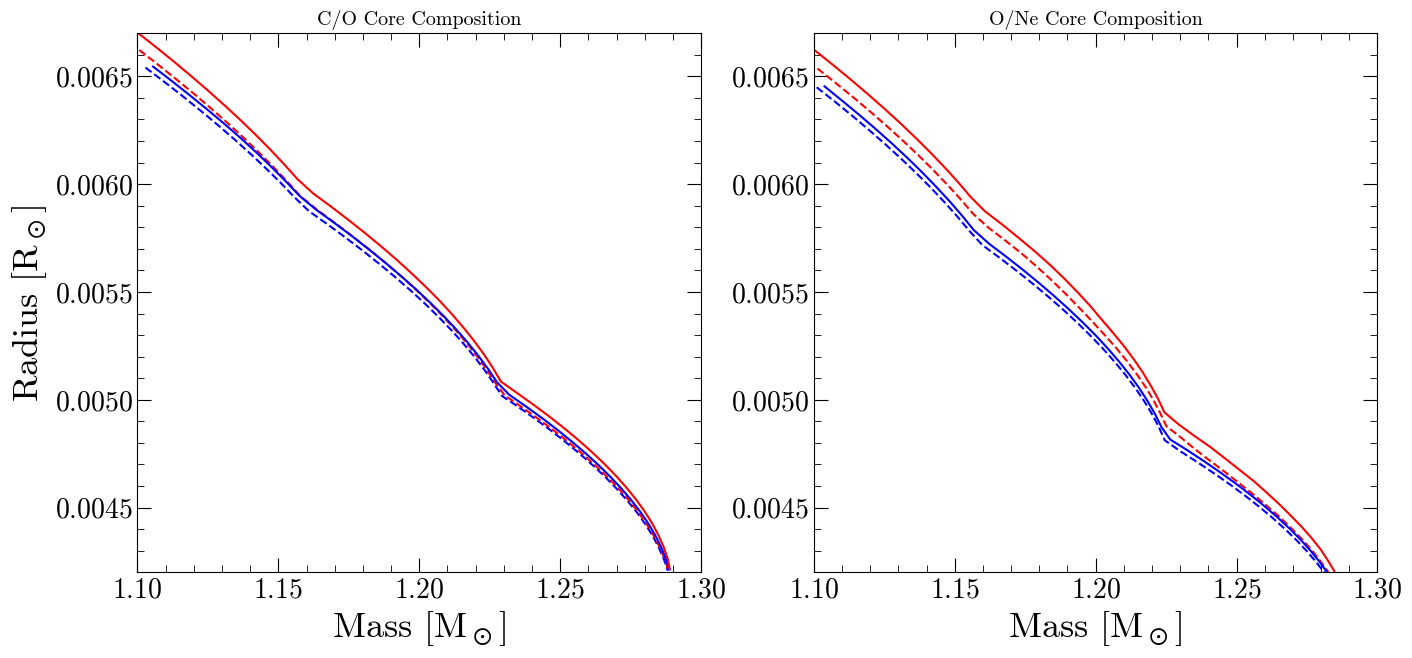

In [ ]:
co_hdef_temp_masses = np.array([co_hdef_mass[0,:], co_hdef_mass[1,:]])
co_hdef_temp_radius = np.array([co_hdef_radius[0,:], co_hdef_radius[1,:]])
mr_co_hdef_temp = [np.column_stack([x,y]) for x, y in zip(co_hdef_temp_masses, co_hdef_temp_radius)]

co_hrich_temp_masses = np.array([co_hrich_mass[0,:], co_hrich_mass[1,:]])
co_hrich_temp_radius = np.array([co_hrich_radius[0,:], co_hrich_radius[1,:]])
mr_co_hrich_temp = [np.column_stack([x,y]) for x, y in zip(co_hrich_temp_masses, co_hrich_temp_radius)]

one_hdef_temp_masses = np.array([one_hdef_mass[0,:], one_hdef_mass[1,:]])
one_hdef_temp_radius = np.array([one_hdef_radius[0,:], one_hdef_radius[1,:]])
mr_one_hdef_temp = [np.column_stack([x,y]) for x, y in zip(one_hdef_temp_masses, one_hdef_temp_radius)]

one_hrich_temp_masses = np.array([one_hrich_mass[0,:], one_hrich_mass[1,:]])
one_hrich_temp_radius = np.array([one_hrich_radius[0,:], one_hrich_radius[1,:]])
mr_one_hrich_temp = [np.column_stack([x,y]) for x, y in zip(one_hrich_temp_masses, one_hrich_temp_radius)]

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(16, 7))

ax1.set_title('C/O Core Composition')

ax1.set_xlim(1.1, 1.3)
ax1.set_ylim(0.0042, 0.0067)
mr_co_hdef_collection = LineCollection(mr_co_hdef_temp, colors=['blue', 'red'], ls = '--', label='C/O H-Thin')
ax1.add_collection(mr_co_hdef_collection)
mr_co_hrich_collection = LineCollection(mr_co_hrich_temp, colors=['blue', 'red'], ls = '-', label='C/O H-Thick')
ax1.add_collection(mr_co_hrich_collection)

ax1.set_xlabel(r'Mass $[M_\odot]$')
ax1.set_ylabel(r'Radius $[R_\odot]$')



ax2.set_title('O/Ne Core Composition')

ax2.set_xlim(1.1, 1.3)
ax2.set_ylim(0.0042, 0.0067)
mr_one_hdef_collection = LineCollection(mr_one_hdef_temp, colors=['blue', 'red'], ls = '--', label='O/Ne H-Thin')
ax2.add_collection(mr_one_hdef_collection)
mr_one_hrich_collection = LineCollection(mr_one_hrich_temp, colors=['blue', 'red'], ls = '-', label='O/Ne H-Thick')
ax2.add_collection(mr_one_hrich_collection)

ax2.set_xlabel(r'Mass $[M_\odot]$')


## Plot GravZ Models

Text(0.5, 0, 'Radius $[R_\\odot]$')

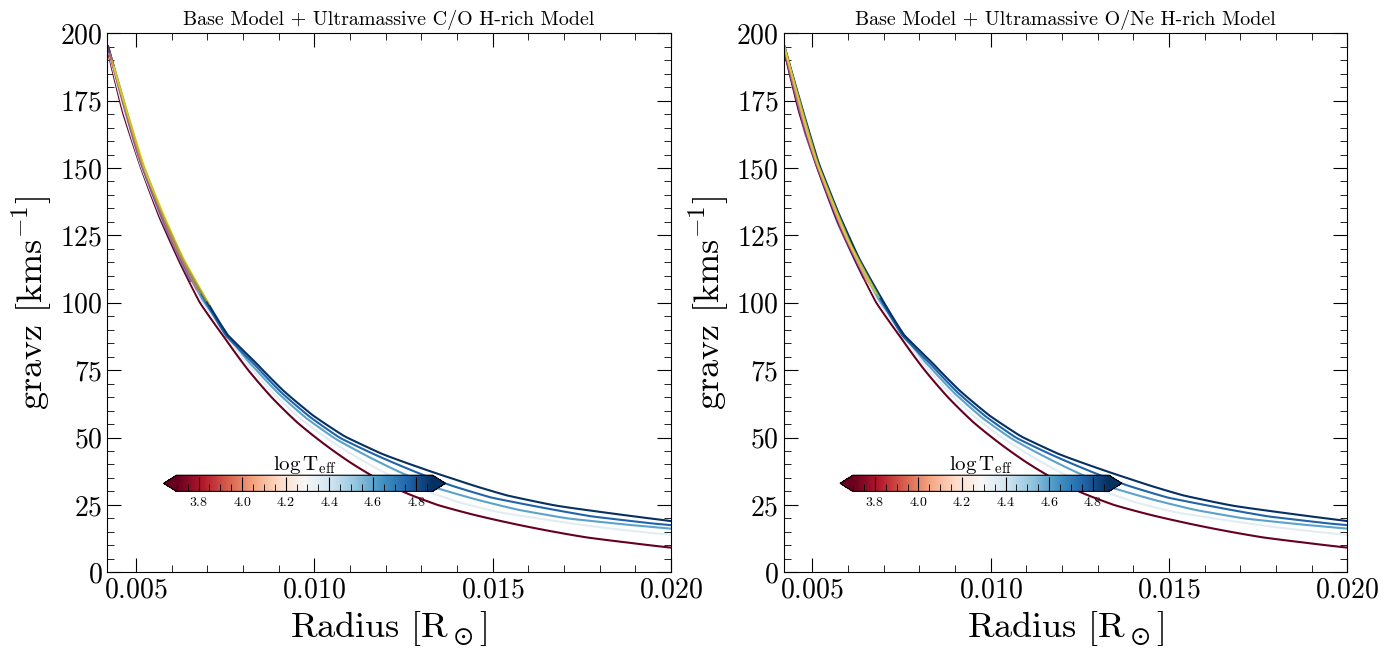

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(16, 7))


vg_base_stack = [np.column_stack([x,y]) for x, y in zip(base_radius, base_vg)]
vg_co_hrich_stack = [np.column_stack([x,y]) for x, y in zip(co_hrich_radius, co_hrich_vg)]
vg_one_hrich_stack = [np.column_stack([x,y]) for x, y in zip(one_hdef_radius, one_hdef_vg)]

ax1.set_xlim(0.0042, 0.02)
ax1.set_ylim(0, 200)
ax1.set_title('Base Model + Ultramassive C/O H-rich Model')

vg_base_collection = LineCollection(vg_base_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='CO H Rich')
ax1.add_collection(vg_base_collection)
vg_co_collection = LineCollection(vg_co_hrich_stack, array=np.log10(teff), cmap='plasma', ls = '-', label='CO H Rich', alpha = 0.5)
ax1.add_collection(vg_co_collection)

cbaxes = ax1.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(vg_base_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax1.set_ylabel(r'gravz $[km s^{-1}]$')
ax1.set_xlabel(r'Radius $[R_\odot]$')




ax2.set_xlim(0.0042, 0.02)
ax2.set_ylim(0, 200)
ax2.set_title('Base Model + Ultramassive O/Ne H-rich Model')

vg_base_collection = LineCollection(vg_base_stack, array=np.log10(teff), cmap='RdBu', ls = '-', label='CO H Rich')
ax2.add_collection(vg_base_collection)
vg_one_collection = LineCollection(vg_one_hrich_stack, array=np.log10(teff), cmap='plasma', ls = '-', label='CO H Rich', alpha = 0.5)
ax2.add_collection(vg_one_collection)

cbaxes = ax2.inset_axes([.1, .15, .5, .03]) 
cb = fig.colorbar(vg_base_collection, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"$\log T_{eff}$",size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax2.set_ylabel(r'gravz $[km s^{-1}]$')
ax2.set_xlabel(r'Radius $[R_\odot]$')

Text(0.5, 0, 'Mass $[M_\\odot]$')

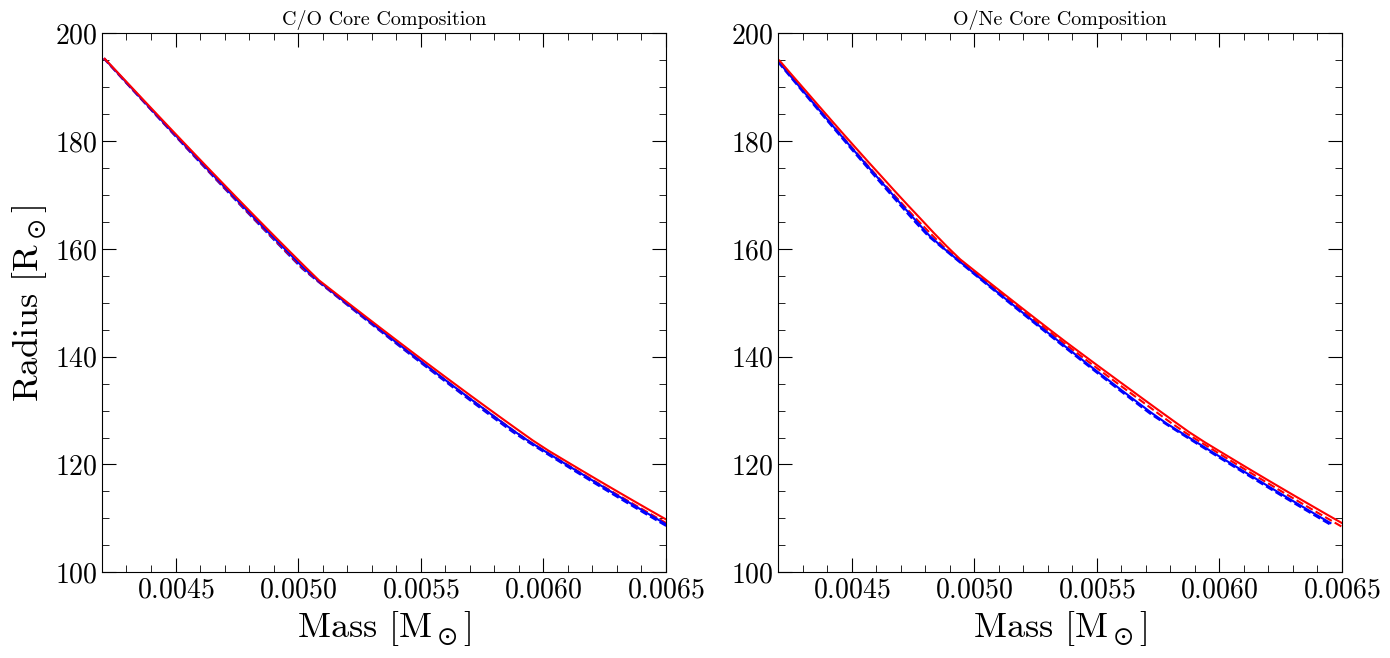

In [ ]:
co_hdef_temp_vg = np.array([co_hdef_vg[0,:], co_hdef_vg[1,:]])
co_hdef_temp_radius = np.array([co_hdef_radius[0,:], co_hdef_radius[1,:]])
vg_co_hdef_temp = [np.column_stack([x,y]) for x, y in zip(co_hdef_temp_radius, co_hdef_temp_vg)]

co_hrich_temp_vg = np.array([co_hrich_vg[0,:], co_hrich_vg[1,:]])
co_hrich_temp_radius = np.array([co_hrich_radius[0,:], co_hrich_radius[1,:]])
vg_co_hrich_temp = [np.column_stack([x,y]) for x, y in zip(co_hrich_temp_radius, co_hrich_temp_vg)]

one_hdef_temp_vg = np.array([one_hdef_vg[0,:], one_hdef_vg[1,:]])
one_hdef_temp_radius = np.array([one_hdef_radius[0,:], one_hdef_radius[1,:]])
vg_one_hdef_temp = [np.column_stack([x,y]) for x, y in zip(one_hdef_temp_radius, one_hdef_temp_vg)]

one_hrich_temp_vg = np.array([one_hrich_vg[0,:], one_hrich_vg[1,:]])
one_hrich_temp_radius = np.array([one_hrich_radius[0,:], one_hrich_radius[1,:]])
vg_one_hrich_temp = [np.column_stack([x,y]) for x, y in zip(one_hrich_temp_radius, one_hrich_temp_vg)]

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(16, 7))

ax1.set_title('C/O Core Composition')

ax1.set_xlim(0.0042, 0.0065)
ax1.set_ylim(100, 200)
mr_co_hdef_collection = LineCollection(vg_co_hdef_temp, colors=['blue', 'red'], ls = '--', label='C/O H-Thin')
ax1.add_collection(mr_co_hdef_collection)
mr_co_hrich_collection = LineCollection(vg_co_hrich_temp, colors=['blue', 'red'], ls = '-', label='C/O H-Thick')
ax1.add_collection(mr_co_hrich_collection)

ax1.set_xlabel(r'Mass $[M_\odot]$')
ax1.set_ylabel(r'Radius $[R_\odot]$')



ax2.set_title('O/Ne Core Composition')

ax2.set_xlim(0.0042, 0.0065)
ax2.set_ylim(100, 200)
mr_one_hdef_collection = LineCollection(vg_one_hdef_temp, colors=['blue', 'red'], ls = '--', label='O/Ne H-Thin')
ax2.add_collection(mr_one_hdef_collection)
mr_one_hrich_collection = LineCollection(vg_one_hrich_temp, colors=['blue', 'red'], ls = '-', label='O/Ne H-Thick')
ax2.add_collection(mr_one_hrich_collection)

ax2.set_xlabel(r'Mass $[M_\odot]$')

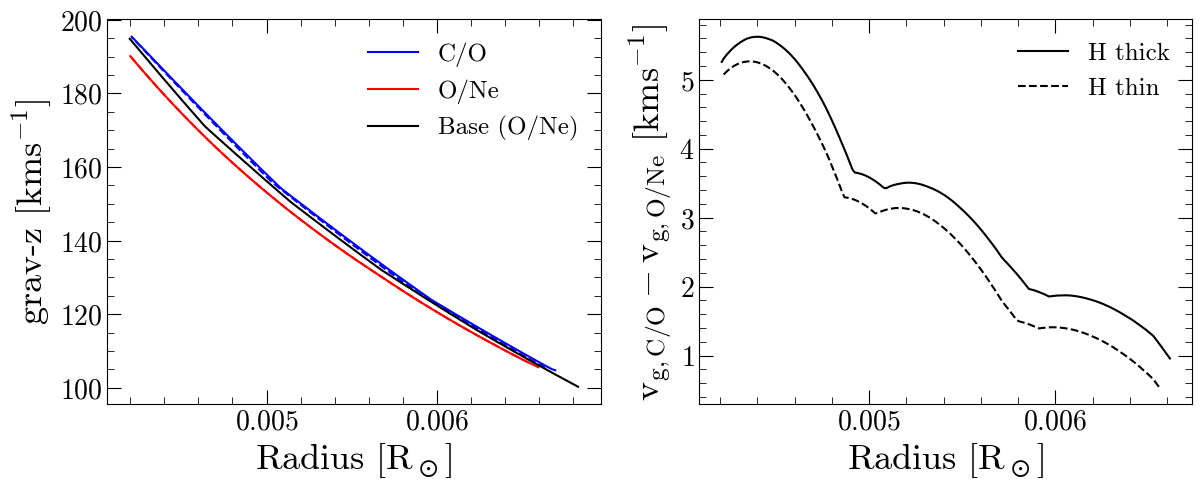

In [ ]:
def get_relation(model, teff):
    logg = np.linspace(8.8, 9.3, 200)
    radii = [model.radius_interp(teff, logg[i]) for i in range(len(logg))]
    masses = [(10**(logg[i] - 2) * (radius_sun * radii[i])**2) / (G * mass_sun) for i in range(len(logg))]    
    vgs = [1e-3 * (G * mass_sun * masses[i]) / (c * radius_sun * radii[i]) for i in range(len(radii))]
    return np.array(radii), np.array(masses), np.array(vgs)

t = 16000
co_hrich_r, co_hrich_m, co_hrich_vg = get_relation(co_hrich_model, t)
co_hdef_r, co_hdef_m, co_hdef_vg = get_relation(co_hdef_model, t)
one_hrich_r, one_hrich_m, one_hrich_vg = get_relation(one_hrich_model, t)
one_hdef_r, one_hdef_m, one_hdef_vg = get_relation(one_hdef_model, t)
base_r, base_m, base_vg = get_relation(base_model, t)

one_hrich_vg = one_model(one_hrich_r, t)
one_hdef_vg = one_model(one_hdef_r, t)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(14, 5))

ax1.plot(co_hrich_r, co_hrich_vg, color='blue', ls='-', label='C/O')
ax1.plot(co_hdef_r, co_hdef_vg, color='blue', ls='--')
ax1.plot(one_hrich_r, one_hrich_vg, color='red', ls='-', label='O/Ne')
ax1.plot(one_hdef_r, one_hdef_vg, color='red', ls='--')
ax1.plot(base_r, base_vg, color='k', ls='-', label='Base (O/Ne)')

ax1.set_xlabel(r'Radius $[R_\odot]$')
ax1.set_ylabel(r'grav-z $[km s^{-1}]$')
ax1.legend(framealpha=0)

ax2.plot(co_hrich_r, co_hrich_vg - one_hrich_vg, color='k', ls='-', label='H thick')
ax2.plot(co_hdef_r, co_hdef_vg - one_hdef_vg, color='k', ls='--', label='H thin')

ax2.set_xlabel(r'Radius $[R_\odot]$')
ax2.set_ylabel(r'$v_{g,\text{C/O}} - v_{g,\text{O/Ne}}$ $[km s^{-1}]$')
ax2.legend(framealpha=0)


In [ ]:
rad_array = np.linspace(0.004, 0.007, 100)
vg_array_one = one_model(rad_array, 16000)
vg_array_co = co_model(rad_array, 16000)

Text(0.5, 1.0, 'C/O')

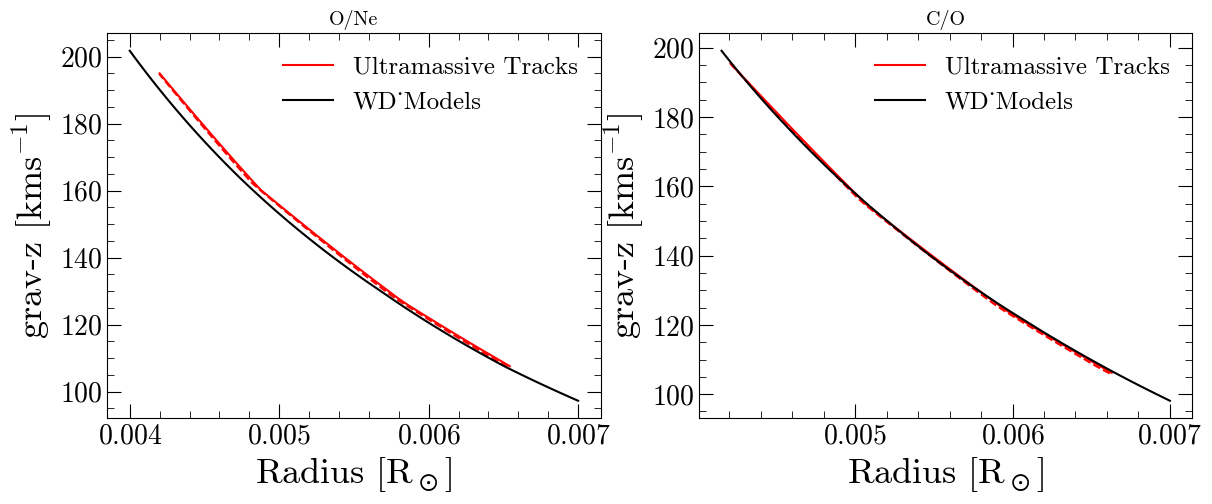

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(14, 5))

ax1.plot(one_hrich_r, one_hrich_vg, c = 'r', ls = '-', label='Ultramassive Tracks')
ax1.plot(one_hdef_r, one_hdef_vg, c = 'r', ls = '--')

ax1.plot(rad_array, vg_array_one, c = 'k', label='WD_Models')

ax1.set_xlabel(r'Radius $[R_\odot]$')
ax1.set_ylabel(r'grav-z $[km s^{-1}]$')
ax1.legend(framealpha=0)
ax1.set_title('O/Ne')

ax2.plot(co_hrich_r, co_hrich_vg, c = 'r', ls = '-', label='Ultramassive Tracks')
ax2.plot(co_hdef_r, co_hdef_vg, c = 'r', ls = '--')

ax2.plot(rad_array, vg_array_co, c = 'k', label='WD_Models')

ax2.set_xlabel(r'Radius $[R_\odot]$')
ax2.set_ylabel(r'grav-z $[km s^{-1}]$')
ax2.legend(framealpha=0)
ax2.set_title('C/O')